# Template for hackathon projects

This notebook simulates a generic satellite experiment in a way that can be easily customized for your project

In [1]:
import os
import sys

import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import toast
import toast.pipeline_tools
from toast.mpi import MPI


# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = None

# Load common tools for all lessons
import sys
sys.path.insert(0, "../lessons")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

Running on NERSC machine 'cori'
  with access to repos: mp107, m2798, m3085, m1759
Using default repo mp107


## Parameters

These arguments control the entire notebook

In [2]:
class args:
    sample_rate = 10  # Hz
    nsample_obs = 10000  # length of an observation in samples
    nobs = 12  # Number of observations
    # Noise parameters
    fknee = 1.0
    alpha = 2
    # half-wave plate
    hwp_rpm = None
    hwp_step_deg = None
    hwp_step_time_s = None
    # Scanning parameters
    spin_period_min = 1 # 10
    spin_angle_deg = 20 # 30
    prec_period_min = 100 # 50
    prec_angle_deg = 30 # 65
    coord = "E"
    nside = 64
    nnz = 3
    outdir = "maps"
    fov = 3.0  # Field-of-view in degrees
    # Projection parameters
    coord = "C"
    nside = 64
    mode = "IQU"
    outdir = "maps"

## Focalplane

In [3]:
focalplane = toast.pipeline_tools.Focalplane(
    fake_focalplane(fov=args.fov, fknee=args.fknee, alpha=args.alpha),
    sample_rate=args.sample_rate, 
)

## TODSatellite to `toast.data`

In [4]:
mpiworld, procs, rank = toast.mpi.get_world()
comm = toast.mpi.Comm(mpiworld)

data = toast.Data(comm)

start_sample = 0
start_time = 0
for iobs in range(args.nobs):    
    tod = toast.todmap.TODSatellite(
        comm.comm_group,
        focalplane.detquats,
        args.nsample_obs,
        coord=args.coord,
        firstsamp=start_sample,
        firsttime=start_time,
        rate=args.sample_rate,
        spinperiod=args.spin_period_min,
        spinangle=args.spin_angle_deg,
        precperiod=args.prec_period_min,
        precangle=args.prec_angle_deg,
        detranks=comm.group_size,
        hwprpm=args.hwp_rpm,
        hwpstep=args.hwp_step_deg,
        hwpsteptime=args.hwp_step_time_s,
    )

    # Constantly slewing precession axis                                                                                                                                             
    precquat = np.empty(4 * tod.local_samples[1], dtype=np.float64).reshape((-1, 4))
    toast.todmap.slew_precession_axis(
        precquat,
        firstsamp=start_sample + tod.local_samples[0],
        samplerate=args.sample_rate,
        degday=360.0 / 365.25,
    )
    tod.set_prec_axis(qprec=precquat)

    obs = {}
    obs["name"] = "science_{:05d}".format(iobs)
    obs["tod"] = tod
    obs["intervals"] = None
    obs["baselines"] = None
    obs["noise"] = focalplane.noise
    obs["id"] = iobs

    data.obs.append(obs)
    
    start_sample += args.nsample_obs
    start_time += args.nsample_obs / args.sample_rate

## Pointing matrix

Here we translate the boresight quaternions into detector pointing (pixels numbers and Stokes weights).

In [5]:
toast.todmap.OpPointingHpix(nside=args.nside, nest=True, mode=args.mode).exec(data)

Make a boolean hit map for diagnostics

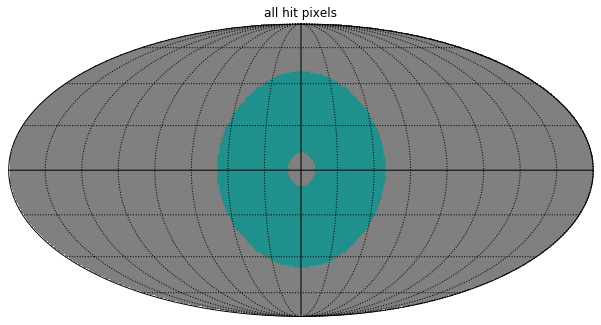

In [6]:
npix = 12 * args.nside ** 2
hitmap = np.zeros(npix)
for obs in data.obs:
    tod = obs["tod"]
    for det in tod.local_dets:
        pixels = tod.cache.reference("pixels_{}".format(det))
        hitmap[pixels] = 1
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, nest=True, title="all hit pixels", cbar=False)
hp.graticule(22.5, verbose=False)

## Sky signal

Create a synthetic Gaussian map to scan as input signal

Sigma is 382.194810 arcmin (0.111176 rad) 
-> fwhm is 900.000000 arcmin


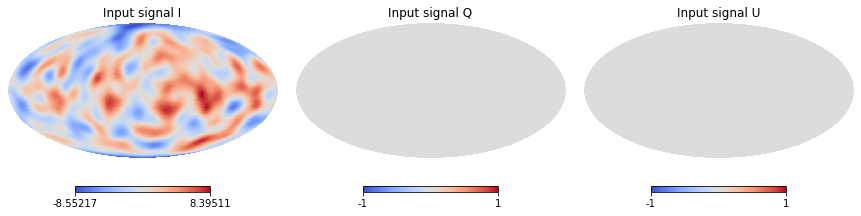

In [7]:
lmax = args.nside * 2
cls = np.zeros([4, lmax + 1])
cls[0] = 1e0
sim_map = hp.synfast(cls, args.nside, lmax=lmax, fwhm=np.radians(15), new=True)
plt.figure(figsize=[12, 8])
for i, m in enumerate(sim_map):
    hp.mollview(sim_map[i], cmap="coolwarm", title="Input signal {}".format("IQU"[i]), sub=[1, 3, 1+i])
hp.write_map("sim_map.fits", hp.reorder(sim_map, r2n=True), nest=True, overwrite=True)

Scan the sky signal

In [8]:
full_name = "signal"
sky_name = "sky_signal"

# Clear any lingering sky signal from the buffers
toast.tod.OpCacheClear(full_name).exec(data)

distmap = toast.map.DistPixels(
    data,
    nnz=len(args.mode),
    dtype=np.float32,
)
distmap.read_healpix_fits("sim_map.fits")
toast.todmap.OpSimScan(distmap=distmap, out=full_name).exec(data)

# Copy the sky signal, just in case we need it later

toast.tod.OpCacheCopy(input=full_name, output=sky_name, force=True).exec(data)

## Noise

Simulate noise and make a copy of signal+noise in case we need it later

In [9]:
copy_name = "signal_copy"

toast.tod.OpSimNoise(out=full_name, realization=0).exec(data)

toast.tod.OpCacheCopy(input=full_name, output=copy_name, force=True).exec(data)

## Your own operator here

Here we define an empty operator you can work with

In [10]:
class MyOperator(toast.Operator):
    def __init__(self, name="signal"):
        """ Arguments:
        name(str) : Cache prefix to operate on
        """
        self._name = name
    
    def exec(self, data):
        # We loop here over all local data but do nothing with it.
        for obs in data.obs:
            tod = obs["tod"]
            for det in tod.local_dets:
                signal = tod.local_signal(det, self._name)

Then we apply the operator to the data

In [11]:
toast.tod.OpCacheCopy(input=copy_name, output=full_name, force=True).exec(data)
MyOperator(name=full_name).exec(data)

Plot a short segment of the signal before and after the operator

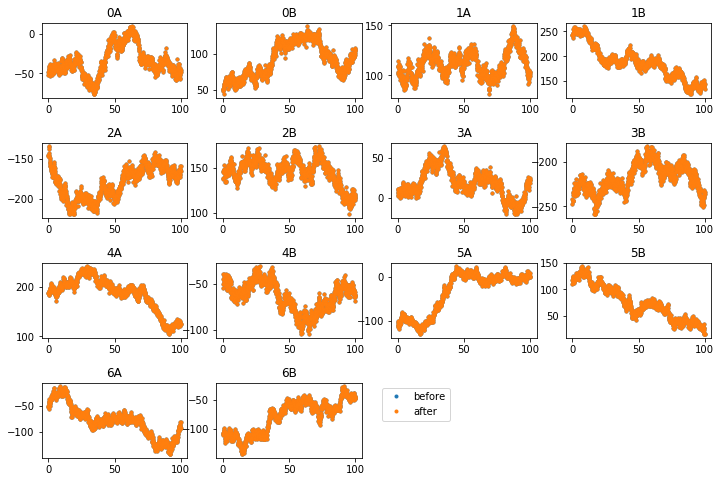

In [12]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    cflags = tod.local_common_flags()
    before = tod.local_signal(det, copy_name)
    after = tod.local_signal(det, full_name)

    ind = slice(0, 1000)
    # Flag out turnarounds
    good = cflags[ind] == 0
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind][good], before[ind][good], '.', label="before")
    ax.plot(times[ind][good], after[ind][good], '.', label="after")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)

## Make a map

Destripe the signal and make a map.  We use the nascent TOAST mapmaker because it can be run in serial mode without MPI.  The TOAST mapmaker is still significantly slower so production runs should used `libMadam`.

In [13]:
# Always begin mapmaking by copying the simulated signal.

toast.tod.OpCacheCopy(input=copy_name, output=full_name, force=True).exec(data)

mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=3,
    name=full_name,
    outdir=args.outdir,
    outprefix="toast_test_",
    baseline_length=10,
    iter_max=100,
    use_noise_prior=False,
)
mapmaker.exec(data)

TOAST INFO: Flag gaps:  0.00 seconds (1 calls)
TOAST INFO: Get detector weights:  0.01 seconds (1 calls)
TOAST INFO: Identify local submaps:  0.00 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  0.10 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote hits to maps/toast_test_hits.fits
TOAST INFO: Write hits:  0.02 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to maps/toast_test_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.03 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.08 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to maps/toast_test_rcond.fits
TOAST INFO: Write rcond:  0.01 seconds (1 calls)
TOAST INFO: Invert N_pp'^1:  0.02 seconds (1 calls)
TOAST INFO: Wrote white noise covariance to maps/toast_test_npp.fits
TOAST INFO: Write N_pp':  0.02 seconds (1 calls)
TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply noise covariance:  0.00 seconds (0 cal

Plot a segment of the timelines

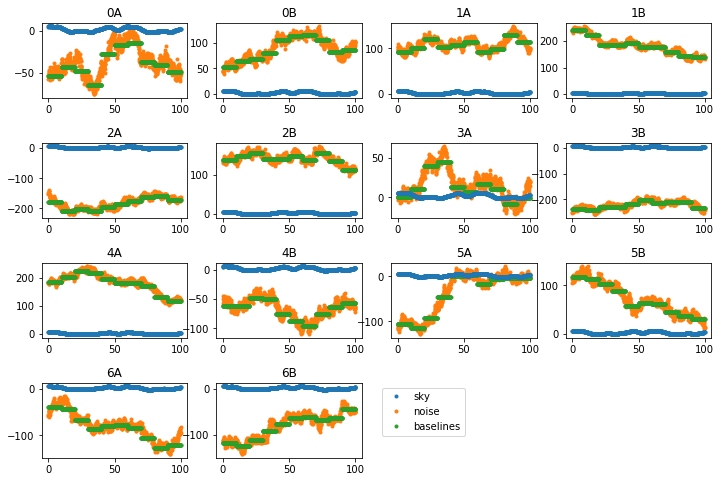

In [14]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, sky_name)
    full = tod.local_signal(det, copy_name)
    cleaned = tod.local_signal(det, full_name)

    ind = slice(0, 1000)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind], sky[ind], '.', label="sky", zorder=100)
    ax.plot(times[ind], full[ind] - sky[ind], '.', label="noise")
    ax.plot(times[ind], full[ind] - cleaned[ind], '.', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)


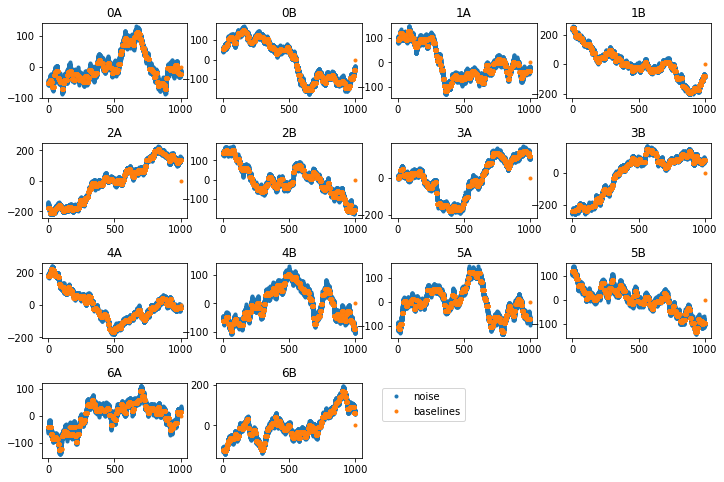

In [15]:
fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, sky_name)
    full = tod.local_signal(det, copy_name)
    cleaned = tod.local_signal(det, full_name)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    #plt.plot(times[ind], sky[ind], '-', label="signal", zorder=100)
    plt.plot(times, full - sky, '.', label="noise")
    plt.plot(times, full - cleaned, '.', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=.6)

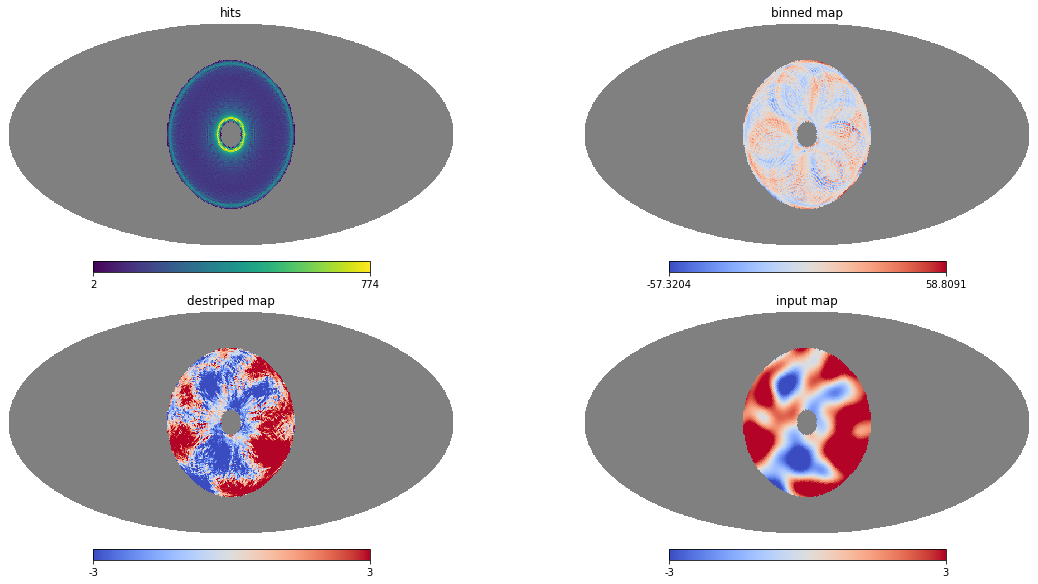

In [16]:
plt.figure(figsize=[16, 8])

hitmap = hp.read_map("maps/toast_test_hits.fits", verbose=False)
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, sub=[2, 2, 1], title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits", verbose=False)
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[2, 2, 2], title="binned map", cmap="coolwarm")

# Fix the plotting range for input signal and the destriped map
amp = 3.0

destriped = hp.read_map("maps/toast_test_destriped.fits", verbose=False)
destriped[destriped == 0] = hp.UNSEEN
# Remove monopole
good = destriped != hp.UNSEEN
destriped[good] -= np.median(destriped[good])
hp.mollview(destriped, sub=[2, 2, 3], title="destriped map", cmap="coolwarm", min=-amp, max=amp)

inmap = hp.read_map("sim_map.fits", verbose=False)
inmap[hitmap == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[2, 2, 4], title="input map", cmap="coolwarm", min=-amp, max=amp)


NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


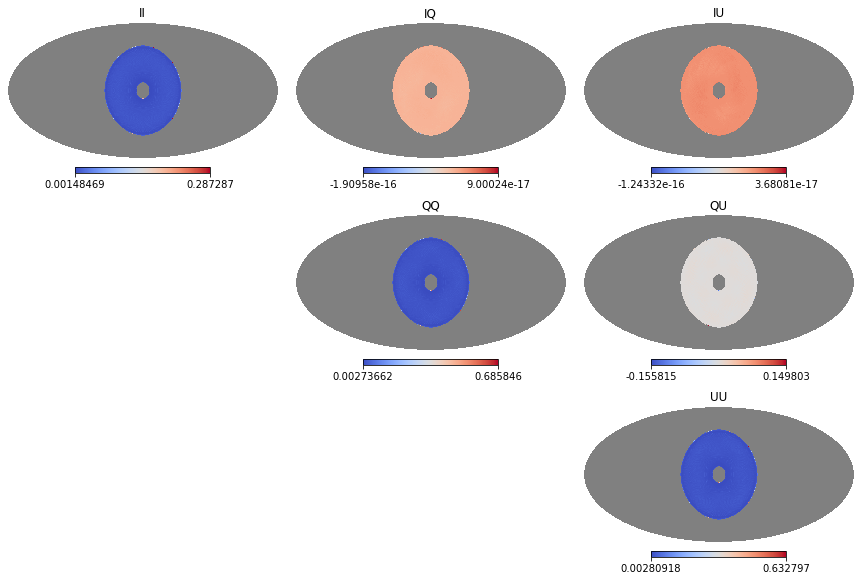

In [17]:
# Plot the white noise covariance

plt.figure(figsize=[12, 8])
wcov = hp.read_map("maps/toast_test_npp.fits", None)
wcov[:, wcov[0] == 0] = hp.UNSEEN
hp.mollview(wcov[0], sub=[3, 3, 1], title="II", cmap="coolwarm")
hp.mollview(wcov[1], sub=[3, 3, 2], title="IQ", cmap="coolwarm")
hp.mollview(wcov[2], sub=[3, 3, 3], title="IU", cmap="coolwarm")
hp.mollview(wcov[3], sub=[3, 3, 5], title="QQ", cmap="coolwarm")
hp.mollview(wcov[4], sub=[3, 3, 6], title="QU", cmap="coolwarm")
hp.mollview(wcov[5], sub=[3, 3, 9], title="UU", cmap="coolwarm")

## Filter & bin

A filter-and-bin mapmaker is easily created by combining TOAST filter operators and running the mapmaker without destriping:

TOAST INFO: Flag gaps:  0.00 seconds (1 calls)
TOAST INFO: Get detector weights:  0.01 seconds (1 calls)
TOAST INFO: Identify local submaps:  0.00 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  0.04 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote hits to maps/toast_test_filtered_hits.fits
TOAST INFO: Write hits:  0.01 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to maps/toast_test_filtered_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.02 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.01 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to maps/toast_test_filtered_rcond.fits
TOAST INFO: Write rcond:  0.01 seconds (1 calls)
TOAST INFO: Invert N_pp'^1:  0.02 seconds (1 calls)
TOAST INFO: Wrote white noise covariance to maps/toast_test_filtered_npp.fits
TOAST INFO: Write N_pp':  0.04 seconds (1 calls)
TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply no

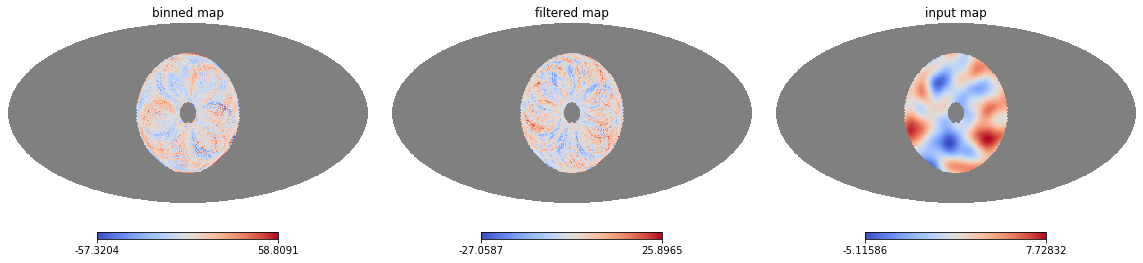

In [18]:
filtered_name = "filtered"

toast.tod.OpCacheCopy(input=copy_name, output=filtered_name, force=True).exec(data)

toast.tod.OpPolyFilter(order=3, name=filtered_name).exec(data)

mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=len(args.mode),
    name=filtered_name,
    outdir=args.outdir,
    outprefix="toast_test_filtered_",
    baseline_length=None,
)
mapmaker.exec(data)

plt.figure(figsize=[16, 8])

binmap = hp.read_map("maps/toast_test_binned.fits", verbose=False)
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[1, 3, 1], title="binned map", cmap="coolwarm")

filtered_map = hp.read_map("maps/toast_test_filtered_binned.fits", verbose=False)
filtered_map[filtered_map == 0] = hp.UNSEEN
hp.mollview(filtered_map, sub=[1, 3, 2], title="filtered map", cmap="coolwarm")

inmap = hp.read_map("sim_map.fits", verbose=False)
inmap[binmap == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[1, 3, 3], title="input map", cmap="coolwarm")